In [21]:
# -----------------------
# 3️⃣ Step 1 - Build FAISS Index (Only run once or when updating)
# -----------------------


from pathlib import Path
from langchain_community.vectorstores import FAISS   # prefer community import
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

INDEX_DIR = Path("policy_faiss_index").resolve()      # absolute path to index folder
INDEX_FAISS = INDEX_DIR / "index.faiss"
INDEX_PKL = INDEX_DIR / "index.pkl"
POLICY_FILE = Path(r"C:/Users/sanat/LangGraph-Udemy-Course/LangGraphDHS/policies.txt")

embeddings = OpenAIEmbeddings()

def build_faiss_index():
    print("📄 Building FAISS index...")
    docs = TextLoader(str(POLICY_FILE)).load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100).split_documents(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    INDEX_DIR.mkdir(parents=True, exist_ok=True)
    vs.save_local(str(INDEX_DIR))
    print(f"✅ Saved: {INDEX_FAISS.name}, {INDEX_PKL.name} in {INDEX_DIR}")

# Build if missing
if not (INDEX_FAISS.exists() and INDEX_PKL.exists()):
    if not POLICY_FILE.exists():
        raise FileNotFoundError(f"Policy file not found at: {POLICY_FILE}")
    build_faiss_index()

# Now load safely
vectorstore = FAISS.load_local(
    str(INDEX_DIR),
    embeddings,
    index_name="index",
    allow_dangerous_deserialization=True
)
print("✅ FAISS index loaded from:", INDEX_DIR)


📄 Building FAISS index...
✅ Saved: index.faiss, index.pkl in C:\Users\sanat\LangGraph-Udemy-Course\LangGraphDHS\policy_faiss_index
✅ FAISS index loaded from: C:\Users\sanat\LangGraph-Udemy-Course\LangGraphDHS\policy_faiss_index


In [22]:
# ============================================
# 📌 LangGraph + FAISS Retrieval Notebook
# ============================================

# -----------------------
# 1️⃣ Install dependencies (uncomment if running first time)
# -----------------------
# %pip install langgraph langchain langchain-openai faiss-cpu python-dotenv

# -----------------------
# 2️⃣ Imports & API Key Setup
# -----------------------
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

# -----------------------
# 4️⃣ Step 2 - Define LangGraph State
# -----------------------
class State(TypedDict):
    messages: list
    department: str
    retrieved_docs: list
    final_answer: str

# -----------------------
# 5️⃣ Step 3 - Load Models & Vectorstore
# -----------------------
llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.5)
embedding_model = OpenAIEmbeddings()
vectorstore = FAISS.load_local("policy_faiss_index", embedding_model, allow_dangerous_deserialization=True)

memory = ConversationBufferMemory(return_messages=True)

# -----------------------
# ✅ Helper: robustly get last user text (works for dict or BaseMessage)
# -----------------------
def _last_content(state: State) -> str:
    m = state["messages"][-1]
    return m["content"] if isinstance(m, dict) else getattr(m, "content", str(m))

# -----------------------
# 6️⃣ Step 4 - Define Nodes
# -----------------------
def understand_query(state: State) -> State:
    return {**state, "messages": state.get("messages", [])}

def classify_department(state: State) -> State:
    query = _last_content(state)  # fixed: HumanMessage is not subscriptable
    prompt = PromptTemplate.from_template(
        "Classify this query into one department: HR, Finance, or IT:\n\n{query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    department = chain.run(query=query).strip().lower()
    allowed = {"hr", "finance", "it"}
    if department not in allowed:
        department = "hr"  # sensible fallback
    return {**state, "department": department}

def retrieve_docs(state: State) -> State:
    query = _last_content(state)  # fixed: HumanMessage is not subscriptable
    docs = vectorstore.similarity_search(query, k=5) or []
    return {**state, "retrieved_docs": docs}

def filter_docs(state: State) -> State:
    docs = state["retrieved_docs"]
    if not docs:
        return {**state, "retrieved_docs": []}
    combined = "\n\n".join([doc.page_content for doc in docs])
    prompt = PromptTemplate.from_template(
        "Here is some policy content:\n{docs}\n\nFilter out irrelevant or redundant parts and retain the most helpful content."
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    filtered = chain.run(docs=combined)
    return {**state, "retrieved_docs": [filtered]}

def summarize_answer(state: State) -> State:
    content = state["retrieved_docs"][0] if state["retrieved_docs"] else "No relevant policy found."
    prompt = PromptTemplate.from_template(
        "Summarize the following for an employee in simple, helpful language:\n\n{content}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    summary = chain.run(content=content)
    return {**state, "final_answer": summary}

# -----------------------
# 7️⃣ Step 5 - Build Graph
# -----------------------
builder = StateGraph(State)
builder.add_node("UnderstandQuery", understand_query)
builder.add_node("ClassifyDepartment", classify_department)
builder.add_node("RetrieveDocs", retrieve_docs)
builder.add_node("FilterDocs", filter_docs)
builder.add_node("SummarizeAnswer", summarize_answer)

builder.set_entry_point("UnderstandQuery")
builder.add_edge("UnderstandQuery", "ClassifyDepartment")
builder.add_edge("ClassifyDepartment", "RetrieveDocs")
builder.add_edge("RetrieveDocs", "FilterDocs")
builder.add_edge("FilterDocs", "SummarizeAnswer")
builder.add_edge("SummarizeAnswer", END)

graph = builder.compile()

# -----------------------
# 8️⃣ Step 6 - Run Workflow
# -----------------------
def run_query(query: str):
    input_state = {"messages": [HumanMessage(content=query)]}
    result = graph.invoke(input_state)
    print(f"✅ Final Answer:\n{result['final_answer']}")
    return result

# Example run
# run_query("How many casual leaves can I take in a year?")


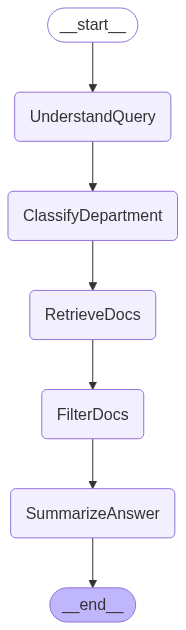

In [26]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
res = run_query("How to reset IT password?")

✅ Final Answer:
**IT Policy: Password Reset**

If you forget your password or think your account might be compromised, go to the IT helpdesk portal to request a password reset. You'll need to verify your employee ID. After that, you'll receive a temporary password in your registered email. Make sure to change this temporary password within 24 hours. Remember, your new password should be at least 12 characters long and include a mix of uppercase letters, lowercase letters, numbers, and special characters.

**IT Policy: Email Access**

You have a company email account for work purposes. If you want to access your email from a personal device, you need to get approval from the IT security team first. Don’t share your email password with anyone, and if you notice anything suspicious, report it to the IT helpdesk right away.


In [25]:
res = run_query("is personal travel expenses covered under travel policy?")

✅ Final Answer:
**Travel Advance Policy:**

- If you're going on an official trip that lasts more than two days, you can ask for a travel advance.
- You need to settle this advance within 15 days after your trip by sending in your actual expenses along with receipts.
- If you don’t spend the full amount, return the leftover money to the company right away.
- If you don’t submit your expense details on time, money will be deducted from your next paycheck.
- Remember, this policy is only for work-related travel, not personal trips.

**Reimbursement Claims Policy:**

- For any work-related expenses (like travel, meals, or accommodation), you must submit your reimbursement claims within 30 days of spending the money.
- Claims submitted after 30 days won’t be accepted unless the Finance Manager approves them for special reasons.
- Make sure to include valid receipts or proof of what you spent.
- You can submit your claims through the Finance portal or by emailing the accounts department usi